# ETL with tf.data

## Librairies

In [14]:
import os

import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
tf.__version__

'2.4.1'

## Paths & Config

In [2]:
DATA_DIR = "data/flower_photos"
CHECKPOINT = "models/classifier-weights.hdf5"
SAVE_MODEL_PATH = "models/classifier.h5"
TENSORBOARD = "logs"

VALIDATION_SPLIT = 0.2

WIDTH = 150
HEIGHT = 150
NUM_CHANNELS = 3
INPUT_SHAPE = (WIDTH, HEIGHT, NUM_CHANNELS)

LEARNING_RATE = 1e-4

EPOCHS = 10
BATCH_SIZE = 16

## Data

In [3]:
# listing all images paths
images = glob.glob(DATA_DIR+'/*/*.*')
np.random.shuffle(images)
n_samples = len(images)
print("Total images:", n_samples)

Total images: 736


In [4]:
classes = [item for item in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, item))]
num_classes = len(classes)
print("Total classes:", num_classes)

Total classes: 10


### Split train, val

In [5]:
train_images, val_images = train_test_split(images, test_size=VALIDATION_SPLIT)

### Build Data Generator

In [6]:
# Key-Value lookup to convert string labels to integer for label model uses
table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(classes, list(range(num_classes))),
    0
)
    
def process_path(file_path):
    label = tf.strings.split(file_path, os.sep)[-2]
    label = table.lookup(label)

    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=NUM_CHANNELS)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize_with_pad(img, WIDTH, HEIGHT)
    img = img*(1./255)

    return img, label

In [7]:
train_ds = tf.data.Dataset.list_files(train_images)
val_ds = tf.data.Dataset.list_files(val_images)

train_ds = train_ds.map(process_path)
train_ds = train_ds.shuffle(1024)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.repeat(EPOCHS)

val_ds = val_ds.map(process_path)
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.repeat(EPOCHS)

## Model Transfer Learning

In [8]:
def build_model(input_shape, num_classes):
    base_model = tf.keras.applications.inception_v3.InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape)

    # Freeze base model
    base_model.trainable = False

    # Build model
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(name='globalaverage2d1'),
        tf.keras.layers.Dense(1024, activation='relu', name='dense1024'),
        tf.keras.layers.Dense(units=num_classes, activation='softmax', name='classifier')
    ])

    return model

model = build_model(INPUT_SHAPE, num_classes)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
globalaverage2d1 (GlobalAver (None, 2048)              0         
_________________________________________________________________
dense1024 (Dense)            (None, 1024)              2098176   
_________________________________________________________________
classifier (Dense)           (None, 10)                10250     
Total params: 23,911,210
Trainable params: 2,108,426
Non-trainable params: 21,802,784
_________________________________________________________________
None


### Loss & Optimizer

In [9]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(lr=LEARNING_RATE),
              metrics=["acc"])

### Callbacks

In [10]:
callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=CHECKPOINT,
                                                         verbose=0,
                                                         save_weights_only=True)
callback_tensorboard = tf.keras.callbacks.TensorBoard(log_dir=TENSORBOARD,
                                                      write_images=True)

callbacks = [callback_checkpoint, callback_tensorboard]

## Training

In [11]:
steps_per_epoch = len(train_images) // BATCH_SIZE + 1
validation_steps = len(val_images) // BATCH_SIZE + 1
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/10
36/36 [==============================] - 275s 6s/step - loss: 2.2824 - acc: 0.0959 - val_loss: 2.2728 - val_acc: 0.1351
Epoch 2/10
36/36 [==============================] - 219s 6s/step - loss: 2.2150 - acc: 0.1615 - val_loss: 2.2713 - val_acc: 0.1554
Epoch 3/10
36/36 [==============================] - 220s 6s/step - loss: 2.1994 - acc: 0.1456 - val_loss: 2.2665 - val_acc: 0.1689
Epoch 4/10
36/36 [==============================] - 220s 6s/step - loss: 2.1990 - acc: 0.1984 - val_loss: 2.2661 - val_acc: 0.1419
Epoch 5/10
36/36 [==============================] - 212s 6s/step - loss: 2.1641 - acc: 0.1990 - val_loss: 2.2630 - val_acc: 0.1959
Epoch 6/10
36/36 [==============================] - 211s 6s/step - loss: 2.1935 - acc: 0.1999 - val_loss: 2.2584 - val_acc: 0.1419
Epoch 7/10
36/36 [==============================] - 211s 6s/step - loss: 2.1406 - acc: 0.1872 - val_loss: 2.2595 - val_acc: 0.1892
Epoch 8/10
36/36 [==============================] - 209s 6s/step - loss: 2.1741 - a

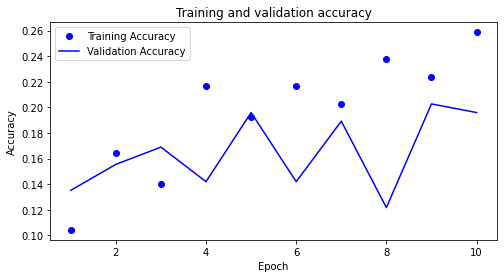

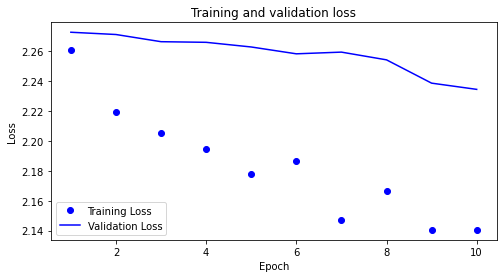

In [15]:
acc = history.history['acc']
loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 4))
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend(loc='best')
plt.show()

## Save model

In [12]:
model.save(SAVE_MODEL_PATH)

# Références
* https://github.com/damienpontifex/mobilenet-classifier-transfer/blob/master/binary_classifier_train.py